# 📏 Adventurer Mart: Outlier Detection & Handling

**Phase 7 of 8: Identify and Handle Outliers in Numerical Data**

## 🎯 Objectives
Detect and appropriately handle outliers to improve model performance and data quality:

1. **Outlier Detection** - Use multiple statistical methods (Z-score, IQR, Modified Z-score)
2. **Outlier Analysis** - Understand outlier patterns and their potential impact
3. **Smart Handling** - Apply appropriate strategies (remove, cap, transform) based on context
4. **Validation** - Ensure outlier handling doesn't compromise data integrity
5. **Documentation** - Track all outlier handling decisions for reproducibility

---

### 📋 Processing Pipeline
- Load optimized numerical data from Phase 6
- Apply multiple outlier detection methods
- Analyze outlier patterns and business context
- Implement appropriate handling strategies
- Validate results and document decisions
- Export cleaned data for temporal feature engineering

In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("📦 Libraries imported successfully!")
print(f"🕐 Notebook started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

📦 Libraries imported successfully!
🕐 Notebook started at: 2025-08-01 13:23:42


## 📥 Load Data from Previous Phase

Loading the cleaned numerical data from Phase 6...

In [2]:
# Load data from previous phase
data_dir = "data_intermediate"

print("📥 Loading data from numerical variables cleaning phase...")

# Load the main cleaned numerical DataFrames
with open(f"{data_dir}/06_cleaned_numeric_dataframes.pkl", "rb") as f:
    dataframes = pickle.load(f)
    
# Load numerical processing logs for context
with open(f"{data_dir}/06_numeric_logs.pkl", "rb") as f:
    numeric_logs = pickle.load(f)

print(f"✅ Loaded {len(dataframes)} cleaned numerical DataFrames")
print(f"📊 Tables: {list(dataframes.keys())}")

# Display current data summary
print("\n📋 Current Data Status:")
total_memory = 0
total_rows = 0
total_numeric_cols = 0

for table_name, df in dataframes.items():
    memory_mb = df.memory_usage(deep=True).sum() / 1024**2
    numeric_cols = len(df.select_dtypes(include=[np.number]).columns)
    
    total_memory += memory_mb
    total_rows += df.shape[0]
    total_numeric_cols += numeric_cols
    
    print(f"   {table_name}: {df.shape[0]:,} rows × {df.shape[1]} cols | {numeric_cols} numeric | {memory_mb:.1f} MB")

print(f"\n📊 Overall Summary:")
print(f"   📊 Total rows: {total_rows:,}")
print(f"   🔢 Total numeric columns: {total_numeric_cols}")
print(f"   💾 Total memory: {total_memory:.1f} MB")

📥 Loading data from numerical variables cleaning phase...
✅ Loaded 9 cleaned numerical DataFrames
📊 Tables: ['details_adventure_gear', 'details_magic_items', 'details_weapons', 'details_armor', 'details_potions', 'details_poisons', 'all_products', 'customers', 'sales']

📋 Current Data Status:
   details_adventure_gear: 106 rows × 24 cols | 12 numeric | 0.0 MB
   details_magic_items: 199 rows × 22 cols | 9 numeric | 0.1 MB
   details_weapons: 37 rows × 27 cols | 15 numeric | 0.0 MB
   details_armor: 13 rows × 44 cols | 13 numeric | 0.0 MB
   details_potions: 22 rows × 17 cols | 9 numeric | 0.0 MB
   details_poisons: 16 rows × 20 cols | 11 numeric | 0.0 MB
   all_products: 393 rows × 18 cols | 8 numeric | 0.1 MB
   customers: 1,423 rows × 17 cols | 12 numeric | 0.4 MB
   sales: 54,126 rows × 24 cols | 18 numeric | 20.1 MB

📊 Overall Summary:
   📊 Total rows: 56,335
   🔢 Total numeric columns: 107
   💾 Total memory: 20.8 MB


## 🔍 Outlier Detection Analysis

Applying multiple statistical methods to detect outliers across all numerical columns...

In [3]:
def detect_outliers_zscore(series, threshold=3):
    """Detect outliers using Z-score method"""
    if len(series.dropna()) < 2:
        return pd.Series(False, index=series.index)
    
    z_scores = np.abs(stats.zscore(series.dropna()))
    outlier_mask = pd.Series(False, index=series.index)
    outlier_mask.loc[series.dropna().index] = z_scores > threshold
    return outlier_mask

def detect_outliers_iqr(series, multiplier=1.5):
    """Detect outliers using IQR method"""
    if len(series.dropna()) < 4:
        return pd.Series(False, index=series.index)
    
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    return (series < lower_bound) | (series > upper_bound)

def detect_outliers_modified_zscore(series, threshold=3.5):
    """Detect outliers using Modified Z-score (MAD-based)"""
    if len(series.dropna()) < 2:
        return pd.Series(False, index=series.index)
    
    median = series.median()
    mad = np.median(np.abs(series - median))
    
    if mad == 0:
        return pd.Series(False, index=series.index)
    
    modified_z_scores = 0.6745 * (series - median) / mad
    return np.abs(modified_z_scores) > threshold

print("🔍 OUTLIER DETECTION ANALYSIS")
print("=" * 50)

# Initialize results tracking
outlier_analysis_results = {}
all_outlier_summaries = {}

# Process each table
for table_name, df in dataframes.items():
    print(f"\n📊 Analyzing outliers in {table_name}...")
    
    # Get numerical columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    if not numeric_cols:
        print(f"   ⚠️ No numerical columns found")
        continue
    
    print(f"   🔢 Analyzing {len(numeric_cols)} numerical columns...")
    
    table_outlier_analysis = {}
    columns_with_outliers = []
    
    for col in numeric_cols:
        if col not in df.columns or df[col].isna().all():
            continue
            
        # Apply different outlier detection methods
        zscore_outliers = detect_outliers_zscore(df[col])
        iqr_outliers = detect_outliers_iqr(df[col])
        mod_zscore_outliers = detect_outliers_modified_zscore(df[col])
        
        # Count outliers for each method
        zscore_count = zscore_outliers.sum()
        iqr_count = iqr_outliers.sum()
        mod_zscore_count = mod_zscore_outliers.sum()
        
        # Calculate percentages
        total_valid = df[col].notna().sum()
        zscore_pct = (zscore_count / total_valid * 100) if total_valid > 0 else 0
        iqr_pct = (iqr_count / total_valid * 100) if total_valid > 0 else 0
        mod_zscore_pct = (mod_zscore_count / total_valid * 100) if total_valid > 0 else 0
        
        # Get basic statistics
        col_stats = {
            'count': total_valid,
            'mean': df[col].mean(),
            'median': df[col].median(),
            'std': df[col].std(),
            'min': df[col].min(),
            'max': df[col].max(),
            'q25': df[col].quantile(0.25),
            'q75': df[col].quantile(0.75)
        }
        
        # Store analysis results
        analysis = {
            'statistics': col_stats,
            'outlier_counts': {
                'zscore': zscore_count,
                'iqr': iqr_count,
                'modified_zscore': mod_zscore_count
            },
            'outlier_percentages': {
                'zscore': zscore_pct,
                'iqr': iqr_pct,
                'modified_zscore': mod_zscore_pct
            },
            'outlier_masks': {
                'zscore': zscore_outliers,
                'iqr': iqr_outliers,
                'modified_zscore': mod_zscore_outliers
            }
        }
        
        table_outlier_analysis[col] = analysis
        
        # Check if column has significant outliers (>5% by any method)
        if max(zscore_pct, iqr_pct, mod_zscore_pct) > 5:
            columns_with_outliers.append(col)
            print(f"     📈 {col}: Z-score: {zscore_pct:.1f}%, IQR: {iqr_pct:.1f}%, Mod-Z: {mod_zscore_pct:.1f}%")
    
    if not columns_with_outliers:
        print(f"   ✅ No significant outliers detected (all methods < 5%)")
    else:
        print(f"   🚨 {len(columns_with_outliers)} columns with significant outliers")
    
    outlier_analysis_results[table_name] = {
        'column_analysis': table_outlier_analysis,
        'columns_with_outliers': columns_with_outliers,
        'summary': {
            'total_numeric_columns': len(numeric_cols),
            'columns_with_outliers': len(columns_with_outliers),
            'outlier_rate': len(columns_with_outliers) / len(numeric_cols) * 100 if numeric_cols else 0
        }
    }

# Overall summary
total_columns_analyzed = sum(len(result['column_analysis']) for result in outlier_analysis_results.values())
total_columns_with_outliers = sum(len(result['columns_with_outliers']) for result in outlier_analysis_results.values())
tables_with_outliers = sum(1 for result in outlier_analysis_results.values() if result['columns_with_outliers'])

print(f"\n📊 OVERALL OUTLIER ANALYSIS SUMMARY:")
print(f"   📋 Tables analyzed: {len(outlier_analysis_results)}")
print(f"   🔢 Total columns analyzed: {total_columns_analyzed}")
print(f"   🚨 Columns with outliers: {total_columns_with_outliers}")
print(f"   📊 Tables with outliers: {tables_with_outliers}")
if total_columns_analyzed > 0:
    print(f"   📈 Overall outlier rate: {total_columns_with_outliers/total_columns_analyzed*100:.1f}%")

🔍 OUTLIER DETECTION ANALYSIS

📊 Analyzing outliers in details_adventure_gear...
   🔢 Analyzing 12 numerical columns...
   ✅ No significant outliers detected (all methods < 5%)

📊 Analyzing outliers in details_magic_items...
   🔢 Analyzing 9 numerical columns...
   ✅ No significant outliers detected (all methods < 5%)

📊 Analyzing outliers in details_weapons...
   🔢 Analyzing 15 numerical columns...
     📈 weight_label: Z-score: 0.0%, IQR: 5.4%, Mod-Z: 0.0%
   🚨 1 columns with significant outliers

📊 Analyzing outliers in details_armor...
   🔢 Analyzing 13 numerical columns...
     📈 ac_was_missing: Z-score: 7.7%, IQR: 7.7%, Mod-Z: 0.0%
   🚨 1 columns with significant outliers

📊 Analyzing outliers in details_potions...
   🔢 Analyzing 9 numerical columns...
     📈 price_freq: Z-score: 0.0%, IQR: 18.2%, Mod-Z: 0.0%
   🚨 1 columns with significant outliers

📊 Analyzing outliers in details_poisons...
   🔢 Analyzing 11 numerical columns...
     📈 dc: Z-score: 0.0%, IQR: 6.2%, Mod-Z: 0.0%
  

## 📊 Outlier Visualization

Creating visualizations to understand outlier patterns...

📊 OUTLIER VISUALIZATION
📈 Visualizing top 6 columns with outliers...


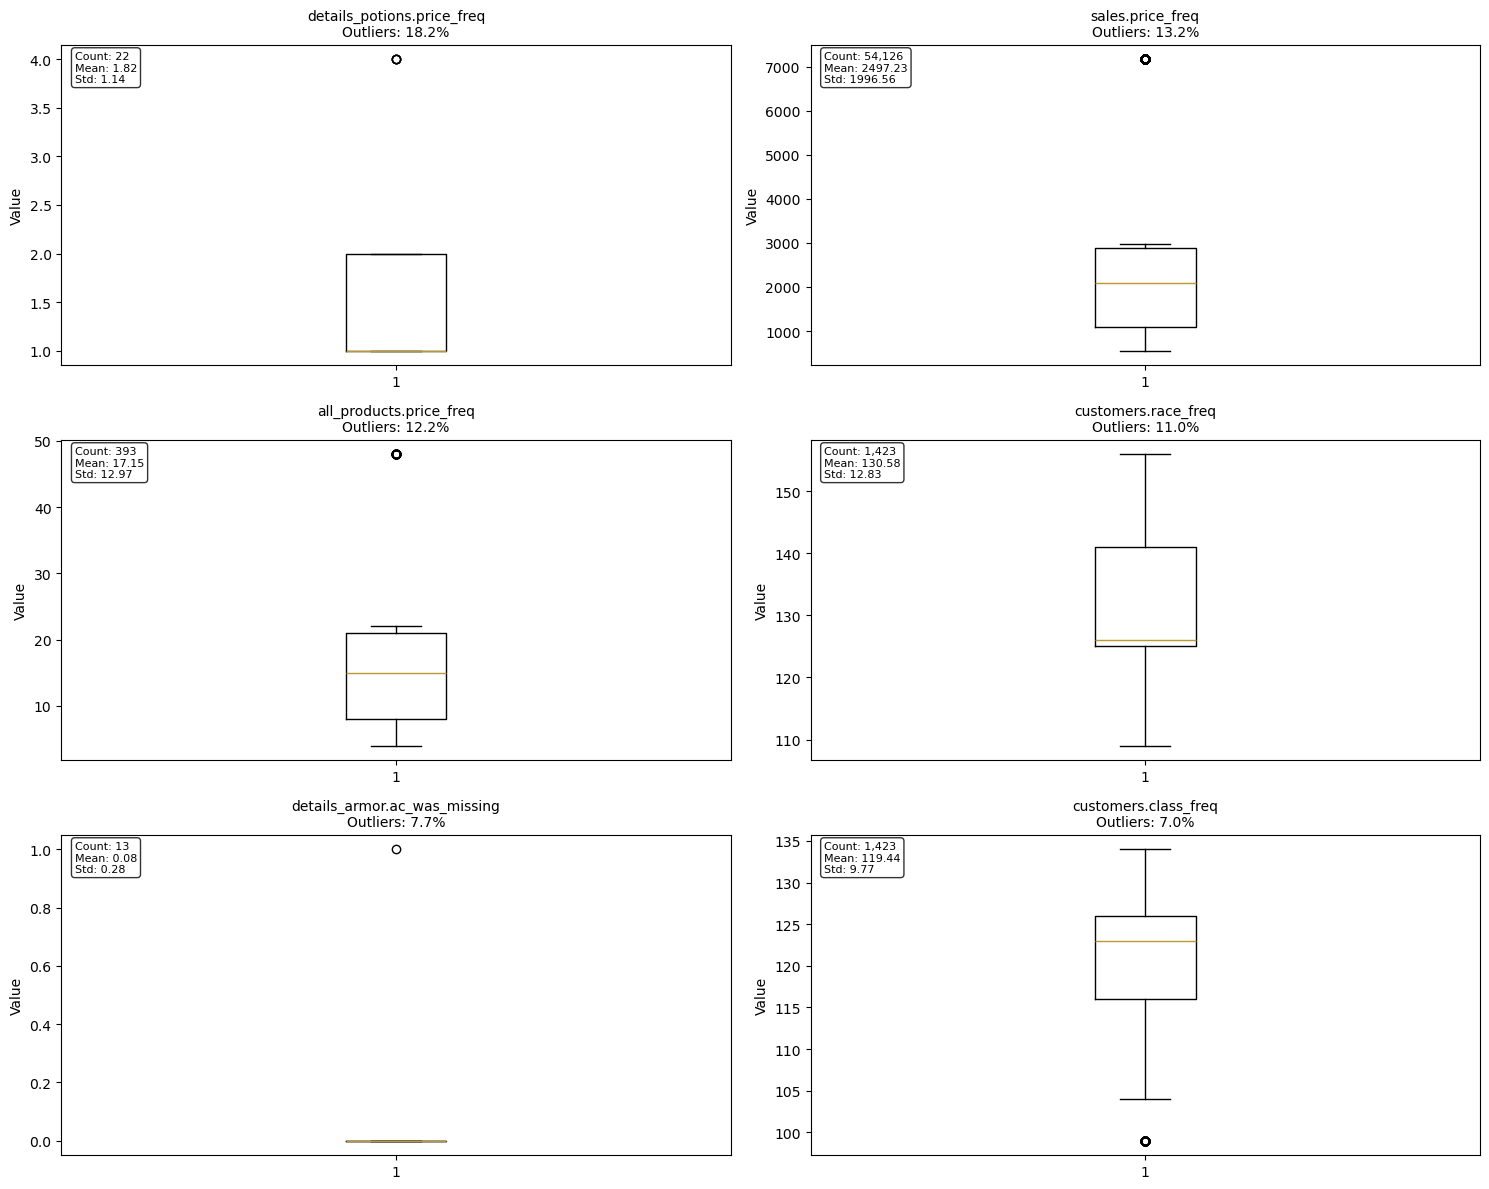


🏆 Top Outlier Candidates:
   1. details_potions.price_freq: 18.2% outliers
   2. sales.price_freq: 13.2% outliers
   3. all_products.price_freq: 12.2% outliers
   4. customers.race_freq: 11.0% outliers
   5. details_armor.ac_was_missing: 7.7% outliers


In [4]:
print("📊 OUTLIER VISUALIZATION")
print("=" * 40)

# Find tables and columns with the most significant outliers for visualization
outlier_candidates = []
for table_name, analysis in outlier_analysis_results.items():
    for col, col_analysis in analysis['column_analysis'].items():
        max_outlier_pct = max(col_analysis['outlier_percentages'].values())
        if max_outlier_pct > 5:  # Only visualize if >5% outliers
            outlier_candidates.append({
                'table': table_name,
                'column': col,
                'outlier_pct': max_outlier_pct,
                'count': col_analysis['statistics']['count']
            })

# Sort by outlier percentage and take top candidates
outlier_candidates.sort(key=lambda x: x['outlier_pct'], reverse=True)
top_candidates = outlier_candidates[:6]  # Visualize top 6

if not top_candidates:
    print("✅ No significant outliers to visualize (all < 5%)")
else:
    print(f"📈 Visualizing top {len(top_candidates)} columns with outliers...")
    
    # Create subplots
    fig_rows = (len(top_candidates) + 1) // 2
    fig, axes = plt.subplots(fig_rows, 2, figsize=(15, 4*fig_rows))
    if fig_rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, candidate in enumerate(top_candidates):
        table_name = candidate['table']
        col = candidate['column']
        outlier_pct = candidate['outlier_pct']
        
        row = i // 2
        col_idx = i % 2
        ax = axes[row, col_idx]
        
        # Get data
        data = dataframes[table_name][col].dropna()
        
        # Create box plot
        ax.boxplot(data, vert=True)
        ax.set_title(f'{table_name}.{col}\nOutliers: {outlier_pct:.1f}%', fontsize=10)
        ax.set_ylabel('Value')
        
        # Add some statistics as text
        stats_text = f'Count: {len(data):,}\nMean: {data.mean():.2f}\nStd: {data.std():.2f}'
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                verticalalignment='top', fontsize=8, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Hide empty subplots
    for i in range(len(top_candidates), fig_rows * 2):
        row = i // 2
        col_idx = i % 2
        axes[row, col_idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Print top outlier candidates summary
    print(f"\n🏆 Top Outlier Candidates:")
    for i, candidate in enumerate(top_candidates[:5], 1):
        print(f"   {i}. {candidate['table']}.{candidate['column']}: {candidate['outlier_pct']:.1f}% outliers")

## 🛠️ Outlier Handling Strategy

Applying appropriate outlier handling strategies based on business context and data characteristics...

In [5]:
def determine_outlier_strategy(col_name, analysis, table_name):
    """Determine the best strategy for handling outliers in a column"""
    stats = analysis['statistics']
    outlier_pcts = analysis['outlier_percentages']
    max_outlier_pct = max(outlier_pcts.values())
    
    # Business logic for different column types
    col_lower = col_name.lower()
    
    # ID columns - never remove outliers
    if any(keyword in col_lower for keyword in ['id', '_id', 'key']):
        return 'keep', 'ID column - preserve all values'
    
    # Count/quantity columns
    if any(keyword in col_lower for keyword in ['count', 'quantity', 'qty', 'amount', 'num_']):
        if max_outlier_pct > 15:
            return 'cap', 'High outlier rate in count column - cap to reduce impact'
        else:
            return 'keep', 'Count column with acceptable outlier rate'
    
    # Price/money columns
    if any(keyword in col_lower for keyword in ['price', 'cost', 'value', 'total', 'revenue']):
        if max_outlier_pct > 10:
            return 'cap', 'Price column - cap extreme values to prevent skew'
        else:
            return 'keep', 'Price column with acceptable outlier rate'
    
    # Percentage/ratio columns
    if any(keyword in col_lower for keyword in ['pct', 'percent', 'ratio', 'rate']):
        if stats['min'] < 0 or stats['max'] > 100:
            return 'cap', 'Percentage column with values outside 0-100 range'
        elif max_outlier_pct > 20:
            return 'remove', 'High outlier rate in percentage column'
        else:
            return 'keep', 'Percentage column within acceptable range'
    
    # General strategy based on outlier percentage
    if max_outlier_pct > 25:
        return 'transform', 'Very high outlier rate - consider transformation'
    elif max_outlier_pct > 15:
        return 'cap', 'High outlier rate - cap extreme values'
    elif max_outlier_pct > 5:
        return 'remove', 'Moderate outlier rate - remove outliers'
    else:
        return 'keep', 'Low outlier rate - keep all values'

def apply_outlier_handling(df, col, strategy, analysis):
    """Apply the chosen outlier handling strategy"""
    original_data = df[col].copy()
    handled_data = df[col].copy()
    
    if strategy == 'keep':
        return handled_data, {'method': 'keep', 'removed': 0, 'modified': 0}
    
    elif strategy == 'remove':
        # Use IQR method for removal (most conservative)
        outliers = analysis['outlier_masks']['iqr']
        handled_data.loc[outliers] = np.nan
        removed_count = outliers.sum()
        return handled_data, {'method': 'remove', 'removed': removed_count, 'modified': 0}
    
    elif strategy == 'cap':
        # Cap to 1st and 99th percentiles
        lower_cap = df[col].quantile(0.01)
        upper_cap = df[col].quantile(0.99)
        
        modified_count = ((df[col] < lower_cap) | (df[col] > upper_cap)).sum()
        handled_data = df[col].clip(lower=lower_cap, upper=upper_cap)
        
        return handled_data, {
            'method': 'cap', 
            'removed': 0, 
            'modified': modified_count,
            'lower_cap': lower_cap,
            'upper_cap': upper_cap
        }
    
    elif strategy == 'transform':
        # Apply log transformation if all values are positive
        if (df[col] > 0).all():
            handled_data = np.log1p(df[col])  # log(1+x) to handle zeros
            return handled_data, {'method': 'log_transform', 'removed': 0, 'modified': len(df[col])}
        else:
            # Fall back to capping if log transform not applicable
            return apply_outlier_handling(df, col, 'cap', analysis)
    
    return handled_data, {'method': 'unknown', 'removed': 0, 'modified': 0}

print("🛠️ OUTLIER HANDLING STRATEGY")
print("=" * 50)

# Initialize tracking
all_outlier_handling_logs = {}
outlier_handling_rules = {}
total_outliers_before = 0
total_outliers_after = 0
total_outliers_reduced = 0

# Apply outlier handling to each table
for table_name, df in dataframes.items():
    if table_name not in outlier_analysis_results:
        continue
    
    analysis = outlier_analysis_results[table_name]
    columns_with_outliers = analysis['columns_with_outliers']
    
    if not columns_with_outliers:
        print(f"\n✅ {table_name}: No outlier handling needed")
        continue
    
    print(f"\n🛠️ Handling outliers in {table_name} ({len(columns_with_outliers)} columns)...")
    
    table_handling_log = {}
    table_rules = {}
    
    for col in columns_with_outliers:
        col_analysis = analysis['column_analysis'][col]
        
        # Determine strategy
        strategy, reason = determine_outlier_strategy(col, col_analysis, table_name)
        
        # Count outliers before handling
        before_outliers = max(col_analysis['outlier_counts'].values())
        total_outliers_before += before_outliers
        
        # Apply handling
        original_data = df[col].copy()
        handled_data, handling_info = apply_outlier_handling(df, col, strategy, col_analysis)
        
        # Update the DataFrame
        df[col] = handled_data
        
        # Re-analyze outliers after handling
        if strategy != 'keep':
            new_iqr_outliers = detect_outliers_iqr(df[col])
            after_outliers = new_iqr_outliers.sum()
        else:
            after_outliers = before_outliers
        
        total_outliers_after += after_outliers
        outliers_reduced = before_outliers - after_outliers
        total_outliers_reduced += outliers_reduced
        
        print(f"   📊 {col}: {strategy.upper()} - {reason}")
        print(f"      Outliers: {before_outliers} → {after_outliers} (reduced: {outliers_reduced})")
        
        # Log the handling
        table_handling_log[col] = {
            'strategy': strategy,
            'reason': reason,
            'handling_info': handling_info,
            'outliers_before': before_outliers,
            'outliers_after': after_outliers,
            'outliers_reduced': outliers_reduced,
            'original_stats': col_analysis['statistics']
        }
        
        table_rules[col] = {
            'strategy': strategy,
            'reason': reason
        }
    
    all_outlier_handling_logs[table_name] = table_handling_log
    outlier_handling_rules[table_name] = table_rules

print(f"\n📊 OUTLIER HANDLING SUMMARY:")
print(f"   🚨 Total outliers before: {total_outliers_before}")
print(f"   ✅ Total outliers after: {total_outliers_after}")
print(f"   📉 Total outliers reduced: {total_outliers_reduced}")
if total_outliers_before > 0:
    reduction_pct = (total_outliers_reduced / total_outliers_before) * 100
    print(f"   📊 Reduction percentage: {reduction_pct:.1f}%")

🛠️ OUTLIER HANDLING STRATEGY

✅ details_adventure_gear: No outlier handling needed

✅ details_magic_items: No outlier handling needed

🛠️ Handling outliers in details_weapons (1 columns)...
   📊 weight_label: REMOVE - Moderate outlier rate - remove outliers
      Outliers: 2 → 0 (reduced: 2)

🛠️ Handling outliers in details_armor (1 columns)...
   📊 ac_was_missing: REMOVE - Moderate outlier rate - remove outliers
      Outliers: 1 → 0 (reduced: 1)

🛠️ Handling outliers in details_potions (1 columns)...
   📊 price_freq: CAP - Price column - cap extreme values to prevent skew
      Outliers: 4 → 4 (reduced: 0)

🛠️ Handling outliers in details_poisons (2 columns)...
   📊 dc: REMOVE - Moderate outlier rate - remove outliers
      Outliers: 1 → 0 (reduced: 1)
   📊 dc_was_missing: REMOVE - Moderate outlier rate - remove outliers
      Outliers: 1 → 0 (reduced: 1)

🛠️ Handling outliers in all_products (1 columns)...
   📊 price_freq: CAP - Price column - cap extreme values to prevent skew
    

## ✅ Post-Handling Validation

Validating that outlier handling improved data quality without compromising integrity...

In [6]:
print("✅ POST-HANDLING VALIDATION")
print("=" * 40)

validation_results = {}
quality_improvements = []

for table_name, df in dataframes.items():
    if table_name not in all_outlier_handling_logs:
        print(f"\n✅ {table_name}: No outlier handling applied")
        continue
    
    print(f"\n🔍 Validating {table_name}...")
    
    handling_log = all_outlier_handling_logs[table_name]
    validation_issues = []
    
    # Check each handled column
    for col, log_entry in handling_log.items():
        if col not in df.columns:
            continue
        
        # Basic validation checks
        current_data = df[col]
        
        # Check for new NaN values (if removal strategy was used)
        if log_entry['strategy'] == 'remove':
            new_nans = current_data.isna().sum() - log_entry['original_stats']['count'] + len(df)
            if new_nans != log_entry['handling_info']['removed']:
                validation_issues.append(f"{col}: Unexpected NaN count after removal")
        
        # Check for infinite values
        if current_data.dtype in ['float32', 'float64']:
            inf_count = np.isinf(current_data).sum()
            if inf_count > 0:
                validation_issues.append(f"{col}: Contains {inf_count} infinite values")
        
        # Check data distribution improvements
        if current_data.notna().sum() > 1:
            try:
                new_std = current_data.std()
                original_std = log_entry['original_stats']['std']
                
                if new_std < original_std:
                    improvement = (original_std - new_std) / original_std * 100
                    quality_improvements.append({
                        'table': table_name,
                        'column': col,
                        'strategy': log_entry['strategy'],
                        'std_reduction_pct': improvement
                    })
            except:
                pass
    
    # Overall table validation
    current_memory = df.memory_usage(deep=True).sum() / 1024**2
    current_rows = len(df)
    current_missing = df.isna().sum().sum()
    
    print(f"   📊 Memory usage: {current_memory:.1f} MB")
    print(f"   📏 Rows: {current_rows:,}")
    print(f"   ❓ Missing values: {current_missing:,}")
    
    if validation_issues:
        print(f"   ⚠️ Issues found: {len(validation_issues)}")
        for issue in validation_issues[:3]:  # Show first 3 issues
            print(f"      - {issue}")
    else:
        print(f"   ✅ No validation issues detected")
    
    validation_results[table_name] = {
        'issues': validation_issues,
        'issue_count': len(validation_issues),
        'current_memory_mb': current_memory,
        'current_rows': current_rows,
        'current_missing': current_missing
    }

# Summary of quality improvements
if quality_improvements:
    print(f"\n📈 QUALITY IMPROVEMENTS:")
    quality_improvements.sort(key=lambda x: x['std_reduction_pct'], reverse=True)
    for improvement in quality_improvements[:5]:  # Top 5 improvements
        print(f"   📊 {improvement['table']}.{improvement['column']}: {improvement['std_reduction_pct']:.1f}% std reduction ({improvement['strategy']})")

total_validation_issues = sum(result['issue_count'] for result in validation_results.values())
print(f"\n📊 VALIDATION SUMMARY:")
print(f"   ⚠️ Total validation issues: {total_validation_issues}")
print(f"   📈 Quality improvements detected: {len(quality_improvements)}")
print(f"   ✅ Outlier handling validation: {'PASSED' if total_validation_issues == 0 else 'ISSUES DETECTED'}")

✅ POST-HANDLING VALIDATION

✅ details_adventure_gear: No outlier handling applied

✅ details_magic_items: No outlier handling applied

🔍 Validating details_weapons...
   📊 Memory usage: 0.0 MB
   📏 Rows: 37
   ❓ Missing values: 2
   ✅ No validation issues detected

🔍 Validating details_armor...
   📊 Memory usage: 0.0 MB
   📏 Rows: 13
   ❓ Missing values: 1
   ✅ No validation issues detected

🔍 Validating details_potions...
   📊 Memory usage: 0.0 MB
   📏 Rows: 22
   ❓ Missing values: 0
   ✅ No validation issues detected

🔍 Validating details_poisons...
   📊 Memory usage: 0.0 MB
   📏 Rows: 16
   ❓ Missing values: 2
   ✅ No validation issues detected

🔍 Validating all_products...
   📊 Memory usage: 0.1 MB
   📏 Rows: 393
   ❓ Missing values: 0
   ✅ No validation issues detected

🔍 Validating customers...
   📊 Memory usage: 0.4 MB
   📏 Rows: 1,423
   ❓ Missing values: 188
   ✅ No validation issues detected

🔍 Validating sales...
   📊 Memory usage: 22.1 MB
   📏 Rows: 54,126
   ❓ Missing valu

## 📊 Final Outlier Handling Summary

Comprehensive summary of all outlier detection and handling operations...

In [7]:
print("📊 OUTLIER HANDLING SUMMARY REPORT")
print("=" * 60)

# Aggregate statistics
total_tables_processed = len(dataframes)
tables_with_outlier_handling = len(all_outlier_handling_logs)
total_columns_handled = sum(len(log) for log in all_outlier_handling_logs.values())

# Strategy usage counts
strategy_counts = {}
for table_log in all_outlier_handling_logs.values():
    for col_log in table_log.values():
        strategy = col_log['strategy']
        strategy_counts[strategy] = strategy_counts.get(strategy, 0) + 1

print(f"🎯 PROCESSING OVERVIEW:")
print(f"   📋 Tables processed: {total_tables_processed}")
print(f"   🛠️ Tables with outlier handling: {tables_with_outlier_handling}")
print(f"   📊 Columns handled: {total_columns_handled}")
print(f"   🚨 Outliers reduced: {total_outliers_reduced:,}")

print(f"\n🛠️ STRATEGY USAGE:")
for strategy, count in sorted(strategy_counts.items()):
    print(f"   {strategy.upper()}: {count} columns")

print(f"\n📈 IMPACT ANALYSIS:")
if total_outliers_before > 0:
    overall_reduction = (total_outliers_reduced / total_outliers_before) * 100
    print(f"   📉 Overall outlier reduction: {overall_reduction:.1f}%")
print(f"   📊 Quality improvements: {len(quality_improvements)} columns")
print(f"   ✅ Validation issues: {sum(result['issue_count'] for result in validation_results.values())}")

# Per-table summary
print(f"\n📋 PER-TABLE SUMMARY:")
summary_data = []
for table_name, df in dataframes.items():
    handling_log = all_outlier_handling_logs.get(table_name, {})
    validation = validation_results.get(table_name, {})
    
    columns_handled = len(handling_log)
    outliers_reduced = sum(log['outliers_reduced'] for log in handling_log.values())
    memory_mb = df.memory_usage(deep=True).sum() / 1024**2
    issues = validation.get('issue_count', 0)
    
    summary_data.append({
        'Table': table_name,
        'Rows': f"{df.shape[0]:,}",
        'Cols_Handled': columns_handled,
        'Outliers_Reduced': outliers_reduced,
        'Memory_MB': f"{memory_mb:.1f}",
        'Issues': issues
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Create comprehensive logs
comprehensive_outlier_logs = {
    'timestamp': datetime.now().isoformat(),
    'processing_summary': {
        'total_tables': total_tables_processed,
        'tables_with_handling': tables_with_outlier_handling,
        'total_columns_handled': total_columns_handled,
        'total_outliers_before': total_outliers_before,
        'total_outliers_after': total_outliers_after,
        'total_outliers_reduced': total_outliers_reduced,
        'overall_reduction_pct': (total_outliers_reduced / total_outliers_before * 100) if total_outliers_before > 0 else 0,
        'strategy_usage': strategy_counts,
        'quality_improvements_count': len(quality_improvements),
        'validation_issues_count': sum(result['issue_count'] for result in validation_results.values())
    },
    'outlier_analysis_results': outlier_analysis_results,
    'handling_logs': all_outlier_handling_logs,
    'handling_rules': outlier_handling_rules,
    'validation_results': validation_results,
    'quality_improvements': quality_improvements
}

print(f"\n✅ Outlier detection and handling completed successfully!")
print(f"📁 Ready for Phase 8: Date & Time Feature Engineering")

📊 OUTLIER HANDLING SUMMARY REPORT
🎯 PROCESSING OVERVIEW:
   📋 Tables processed: 9
   🛠️ Tables with outlier handling: 7
   📊 Columns handled: 10
   🚨 Outliers reduced: 112

🛠️ STRATEGY USAGE:
   CAP: 3 columns
   REMOVE: 7 columns

📈 IMPACT ANALYSIS:
   📉 Overall outlier reduction: 1.5%
   📊 Quality improvements: 6 columns
   ✅ Validation issues: 0

📋 PER-TABLE SUMMARY:
                 Table   Rows  Cols_Handled  Outliers_Reduced Memory_MB  Issues
details_adventure_gear    106             0                 0       0.0       0
   details_magic_items    199             0                 0       0.1       0
       details_weapons     37             1                 2       0.0       0
         details_armor     13             1                 1       0.0       0
       details_potions     22             1                 0       0.0       0
       details_poisons     16             2                 2       0.0       0
          all_products    393             1                 0      

## 💾 Export Results for Next Phase

Saving outlier-handled data and processing logs for temporal feature engineering phase...

In [8]:
# Export outlier-handled dataframes
output_dir = "data_intermediate"
os.makedirs(output_dir, exist_ok=True)

print("💾 Exporting results for temporal feature engineering phase...")

# Save the outlier-handled DataFrames
with open(f"{output_dir}/07_outlier_handled_dataframes.pkl", "wb") as f:
    pickle.dump(dataframes, f)
print(f"   ✅ Saved outlier-handled DataFrames: {len(dataframes)} tables")

# Save comprehensive outlier handling logs
with open(f"{output_dir}/07_outlier_handling_logs.pkl", "wb") as f:
    pickle.dump(comprehensive_outlier_logs, f)
print(f"   ✅ Saved outlier handling logs")

# Save outlier detection results for reference
with open(f"{output_dir}/07_outlier_analysis_results.pkl", "wb") as f:
    pickle.dump(outlier_analysis_results, f)
print(f"   ✅ Saved outlier analysis results")

# Save handling rules for future reference
with open(f"{output_dir}/07_outlier_handling_rules.pkl", "wb") as f:
    pickle.dump(outlier_handling_rules, f)
print(f"   ✅ Saved outlier handling rules")

# Create a summary report
summary_report = {
    'phase': 'Outlier Detection & Handling',
    'timestamp': datetime.now().isoformat(),
    'input_source': '06_cleaned_numeric_dataframes.pkl (from Phase 6)',
    'output_files': [
        '07_outlier_handled_dataframes.pkl',
        '07_outlier_handling_logs.pkl',
        '07_outlier_analysis_results.pkl',
        '07_outlier_handling_rules.pkl'
    ],
    'summary_stats': {
        'tables_processed': total_tables_processed,
        'columns_handled': total_columns_handled,
        'outliers_reduced': total_outliers_reduced,
        'validation_issues': sum(result['issue_count'] for result in validation_results.values()),
        'quality_improvements': len(quality_improvements)
    },
    'next_phase': 'Phase 8: Date & Time Feature Engineering',
    'ready_for_ml': False,
    'notes': [
        'Outliers detected using Z-score, IQR, and Modified Z-score methods',
        'Applied context-aware handling strategies (keep/remove/cap/transform)',
        'Data quality validated after all transformations',
        'Ready for temporal feature engineering and final ML preparation'
    ]
}

with open(f"{output_dir}/07_phase7_summary_report.pkl", "wb") as f:
    pickle.dump(summary_report, f)
print(f"   ✅ Saved phase summary report")

print(f"\n🎉 PHASE 7 COMPLETE!")
print(f"📂 All outputs saved to: {output_dir}/")
print(f"➡️  Next: Run 08_date_time_feature_engineering.ipynb")
print(f"\n📊 Final Summary:")
print(f"   🚨 Outliers reduced: {total_outliers_reduced:,}")
print(f"   🛠️ Columns handled: {total_columns_handled}")
print(f"   📈 Quality improvements: {len(quality_improvements)}")
print(f"   ✅ Data integrity maintained: {sum(result['issue_count'] for result in validation_results.values()) == 0}")

💾 Exporting results for temporal feature engineering phase...
   ✅ Saved outlier-handled DataFrames: 9 tables
   ✅ Saved outlier handling logs
   ✅ Saved outlier analysis results
   ✅ Saved outlier handling rules
   ✅ Saved phase summary report

🎉 PHASE 7 COMPLETE!
📂 All outputs saved to: data_intermediate/
➡️  Next: Run 08_date_time_feature_engineering.ipynb

📊 Final Summary:
   🚨 Outliers reduced: 112
   🛠️ Columns handled: 10
   📈 Quality improvements: 6
   ✅ Data integrity maintained: True
